In [1]:
%run setup.ipynb
%matplotlib inline

## Information gain

In [2]:
callset = phase1_ar31.callset
region_vgsc = SeqFeature('2L', 2358158, 2431617)
chrom = '2L'

In [3]:
@functools.lru_cache(maxsize=None)
def compute_information_gain(start_index=0, stop_index=200000):
    
    # load the data on cluster assignments
    import pickle
    with open('../data/clust_dict.pickle', mode='rb') as f:
        clust_dict = pickle.load(f)
        
    # define the classes - 'WT' means any susceptible
    classes = ['WT'] + sorted(clust_dict)
    n_classes = len(classes)
    
    # load haplotypes
    callset_phased = phase1_ar31.callset_phased
    haps = allel.GenotypeArray(callset_phased[chrom]['calldata/genotype'][start_index:stop_index, :765]).to_haplotypes()
    n_haps = haps.shape[1]
    pos = allel.SortedIndex(callset_phased[chrom]['variants/POS'][start_index:stop_index])
    
    # set up target attribute
    target_attr = np.zeros(n_haps, dtype=int)
    for i, cls in enumerate(classes):
        if i > 0:
            hap_indices = sorted(clust_dict[cls])
            target_attr[hap_indices] = i
            
    # compute entropy for the target attribute
    target_freqs = np.bincount(target_attr, minlength=n_classes) / target_attr.shape[0]
    target_entropy = scipy.stats.entropy(target_freqs)
    
    # setup output array
    gain = np.zeros(pos.shape[0])
    
    # work through the variants one by one
    for i in range(pos.shape[0]):
        
        # pull out the attribute data
        attr = haps[i]
        
        # split on attribute value and compute entropies for each split
        split_entropy = 0
        for v in 0, 1:
            split = target_attr[attr == v]
            if split.shape[0] == 0:
                continue
            split_freqs = np.bincount(split, minlength=len(classes)) / split.shape[0]
            split_entropy += (split.shape[0] / n_haps) * scipy.stats.entropy(split_freqs)
            
        # compute and store gain
        gain[i] = target_entropy - split_entropy
        
    return gain, pos, haps, target_attr

In [4]:
def plot_information_gain(start=None, stop=None, ax=None):
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 3))
        sns.despine(ax=ax, offset=5)
        
    gain, pos, _, _ = compute_information_gain()    
    ax.plot(pos, gain, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
    ax.set_xlabel('Position (bp)')
    ax.set_ylabel('Information gain')
    ax.set_xlim(start, stop)
    ax.set_ylim(bottom=0)
    if fig:
        fig.tight_layout()

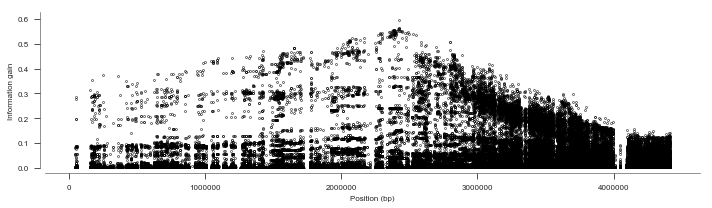

In [5]:
plot_information_gain()

In [6]:
gene_labels

{'AGAP002824': 'Gprtak1',
 'AGAP002825': 'Pp01',
 'AGAP002862': 'Cyp6aa1',
 'AGAP002863': 'Coeae6o',
 'AGAP002865': 'Cyp6p3',
 'AGAP002866': 'Cyp6p5',
 'AGAP002867': 'Cyp6p4',
 'AGAP002868': 'Cyp6p1',
 'AGAP002869': 'Cyp6p2',
 'AGAP002870': 'Cyp6ad1',
 'AGAP002915': 'Pcsk4/furin',
 'AGAP004707': 'Vgsc',
 'AGAP006028': 'Gaba',
 'AGAP009190': 'Gste8',
 'AGAP009191': 'Gste6',
 'AGAP009192': 'Gste5',
 'AGAP009193': 'Gste4',
 'AGAP009194': 'Gste2',
 'AGAP009195': 'Gste1',
 'AGAP009196': 'Gste7',
 'AGAP009197': 'Gste3',
 'AGAP010815': 'Tep1',
 'AGAP013128': 'Cyp6aa2'}

In [7]:
sns.set_style('white')
sns.set_style('ticks')

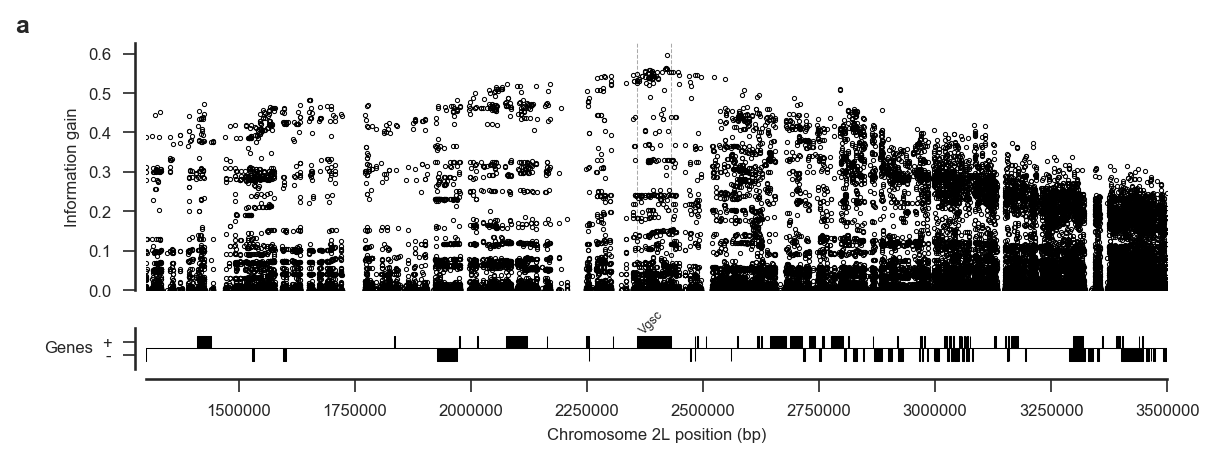

In [8]:
def fig_information_gain(start=int(1.3e6), stop=int(3.5e6)):

    # setup figure
    fig = plt.figure(figsize=(8, 3), dpi=150)
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1])

    # plot information gain
    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=5, bottom=True)
    plot_information_gain(start, stop, ax)
    ax.axvline(region_vgsc.start, zorder=-20, color='#aaaaaa', linestyle='--')
    ax.axvline(region_vgsc.end, zorder=-20, color='#aaaaaa', linestyle='--')
    ax.set_xticks([])
    ax.set_xlabel('')
    
    # plot genes
    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, offset=5)
    plot_genes(phase1_ar3.genome, phase1_ar3.geneset_agamp42_fn, chrom=chrom, start=start, stop=stop, ax=ax, 
               label=True, labels={'AGAP004707': 'Vgsc'}, label_unnamed=False)
    ax.set_xlim(start, stop)
    ax.set_xlabel('Chromosome 2L position (bp)')
    ax.set_ylabel('Genes', rotation=0)
    
    fig.suptitle('a', fontweight='bold', x=0, y=1)
    fig.tight_layout()
    fig.savefig('../artwork/info_gain.png', dpi=150, bbox_inches='tight')

fig_information_gain()

## Decision trees and cross-validation

In [9]:
import sklearn.tree

In [10]:
@functools.lru_cache(maxsize=None)
def eval_trees(start, stop, max_depths=tuple(range(2, 11)), min_samples_leaf=5, criterion='entropy', n_splits=10, random_state=42):
    
    # setup data
    gain, pos, haps, target = compute_information_gain()
    loc = pos.locate_range(start, stop)
    data = haps[loc].T

    # setup cross-validation
    skf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, random_state=random_state)
    
    # setup outputs
    scores = []
    n_features = []
    depths = []
    
    # interate with increasing maximum depth
    for max_depth in max_depths:
        
        # setup the classifier
        clf = sklearn.tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=random_state)
        
        # do cross-validation
        for train_index, test_index in skf.split(data, target):
            
            # split the data
            data_train, data_test = data[train_index], data[test_index]
            target_train, target_test = target[train_index], target[test_index]
            
            # fit the model
            clf.fit(data_train, target_train)
            
            # score the model
            scores.append(clf.score(data_test, target_test))
            
            # store depth and number of features
            depths.append(max_depth)
            n_features.append(np.count_nonzero(clf.feature_importances_))
            assert np.count_nonzero(clf.feature_importances_) == len(set(clf.tree_.feature[clf.tree_.feature >= 0]))

    scores = np.array(scores)
    n_features = np.array(n_features)
    depths = np.array(depths)
    return scores, n_features, depths
  
    

In [11]:
def repeat_eval_trees(start, stop, max_depths=tuple(range(2, 11)), min_samples_leaf=5, criterion='entropy', n_splits=10, n_reps=10):
    scores = []
    n_features = []
    depths = []
    for i in range(n_reps):
        s, f, d = eval_trees(start, stop, max_depths=max_depths, min_samples_leaf=min_samples_leaf, criterion=criterion, n_splits=n_splits, random_state=i)
        scores.extend(s)
        n_features.extend(f)
        depths.extend(d)
    scores = np.array(scores)
    n_features = np.array(n_features)
    depths = np.array(depths)
    return scores, n_features, depths
    

In [12]:
#sns.set_style('darkgrid')

In [13]:
def plot_cv_score(buffer, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    scores, n_features, depths = repeat_eval_trees(start=region_vgsc.start - buffer, stop=region_vgsc.end + buffer, **kwargs)
    ax.plot(n_features, scores, marker='o', mfc='none', mec='k', linestyle=' ', markersize=4)
    ax.set_xlabel('No. SNPs in decision tree')
    ax.set_ylabel('Cross-validation score')
    ax.set_xlim(0, 30)
    ax.set_ylim(top=1)


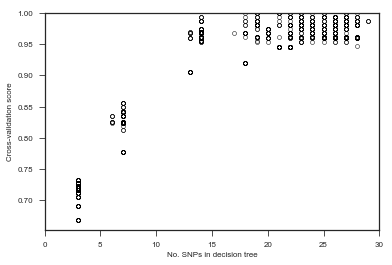

In [14]:
plot_cv_score(20000, criterion='entropy')

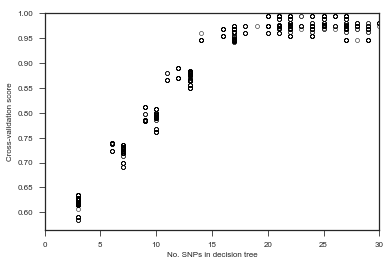

In [15]:
plot_cv_score(20000, criterion='gini')

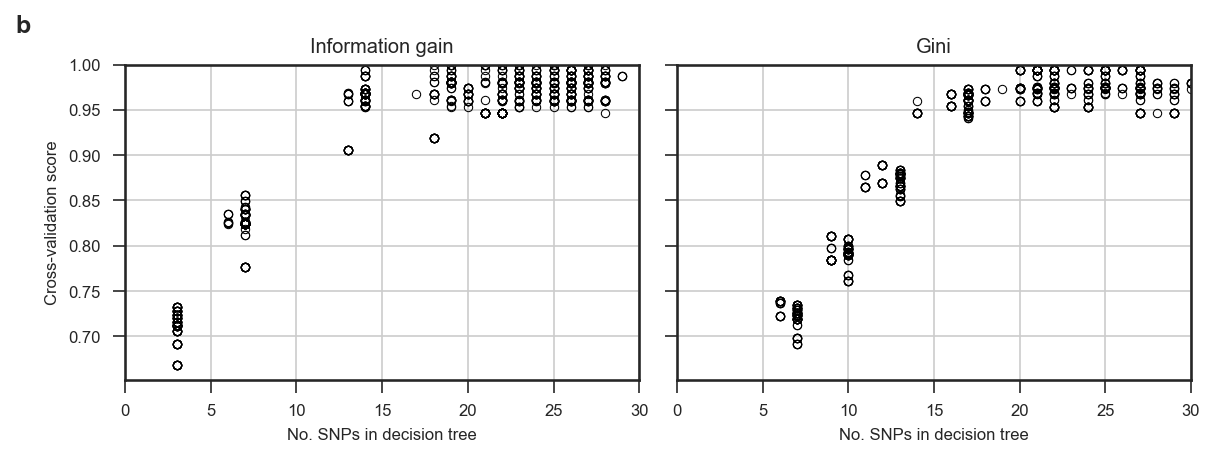

In [16]:
def fig_cv_score(buffer=20000):
    
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 3), dpi=150)
    

    ax = axs[0]
    plot_cv_score(buffer, criterion='entropy', ax=ax)
    ax.set_title('Information gain')
    ax.grid(axis='both')

    ax = axs[1]
    plot_cv_score(buffer, criterion='gini', ax=ax)
    ax.set_title('Gini')
    ax.set_ylabel('')
    ax.grid(axis='both')

    fig.suptitle('b', fontweight='bold', x=0, y=1)
    fig.tight_layout()
    fig.savefig('../artwork/tree_cv.png', bbox_inches='tight', dpi=150)
    
fig_cv_score()


## Additional diagnostics

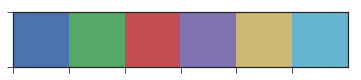

In [17]:
palette = sns.color_palette()
sns.palplot(palette);

In [18]:
def plot_diagnostics(chrom, start, stop, window_size, buffer=1e5):
    start, stop = int(start), int(stop)
    
    # setup data 
    pos = allel.SortedIndex(callset[chrom]['variants/POS'][:])
    filter_pass = callset[chrom]['variants/FILTER_PASS'][:]
    
    # extract region
    loc_region = pos.locate_range(start, stop)
    pos = pos[loc_region]
    filter_pass = filter_pass[loc_region]
    
    # make histogram
    bins = np.arange(start, stop, window_size)
    x = (bins[:-1] + bins[1:]) / 2
    h1, _ = np.histogram(pos, bins=bins)
    y1 = h1 / window_size
    h2, _ = np.histogram(pos[filter_pass], bins=bins)
    y2 = h2 / window_size
    
    # count how many variants within buffer region
    loc_selected = pos.locate_range(region_vgsc.start - buffer, region_vgsc.end + buffer)
    pos_selected = pos[loc_selected]
    filter_pass_selected = filter_pass[loc_selected]
    n_all = pos_selected.shape[0]
    n_pass = np.count_nonzero(filter_pass_selected)
    
    # setup figure
    fig = plt.figure(figsize=(10, 6), dpi=120)
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4])
    
    # plot genes
    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=5)
    plot_genes(phase1_ar3.genome, phase1_ar3.geneset_agamp42_fn, chrom='2L', start=start, stop=stop, ax=ax)
    ax.axvspan(region_vgsc.start - buffer, region_vgsc.end + buffer, zorder=-20, color='#dddddd')
    ax.axvspan(region_vgsc.start, region_vgsc.end, zorder=-20, color='#aaaaaa')
    ax.set_xlim(start, stop)

    # plot variant density
    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, offset=5)
    ax.fill_between(x, 0, y1, color=palette[2], lw=1, label='All (n=%s)' % n_all)
    ax.fill_between(x, 0, y2, color=palette[1], lw=1, label='Pass (n=%s)' % n_pass)
    ax.set_xlabel('Position (bp)')
    ax.set_ylabel('SNP density (per bp)')
    ax.axvspan(region_vgsc.start - buffer, region_vgsc.end + buffer, zorder=-20, color='#dddddd')
    ax.axvspan(region_vgsc.start, region_vgsc.end, zorder=-20, color='#aaaaaa')
    ax.set_xlim(start, stop)
    ax.set_ylim(0, 0.4)
    ax.legend(loc='upper left', ncol=1, frameon=True, framealpha=1)

    # plot information gain
    ax = fig.add_subplot(gs[2])
    sns.despine(ax=ax, offset=5)
    plot_information_gain(start, stop, ax=ax)
    ax.axvspan(region_vgsc.start - buffer, region_vgsc.end + buffer, zorder=-20, color='#dddddd')
    ax.axvspan(region_vgsc.start, region_vgsc.end, zorder=-20, color='#aaaaaa')
    
    fig.tight_layout()

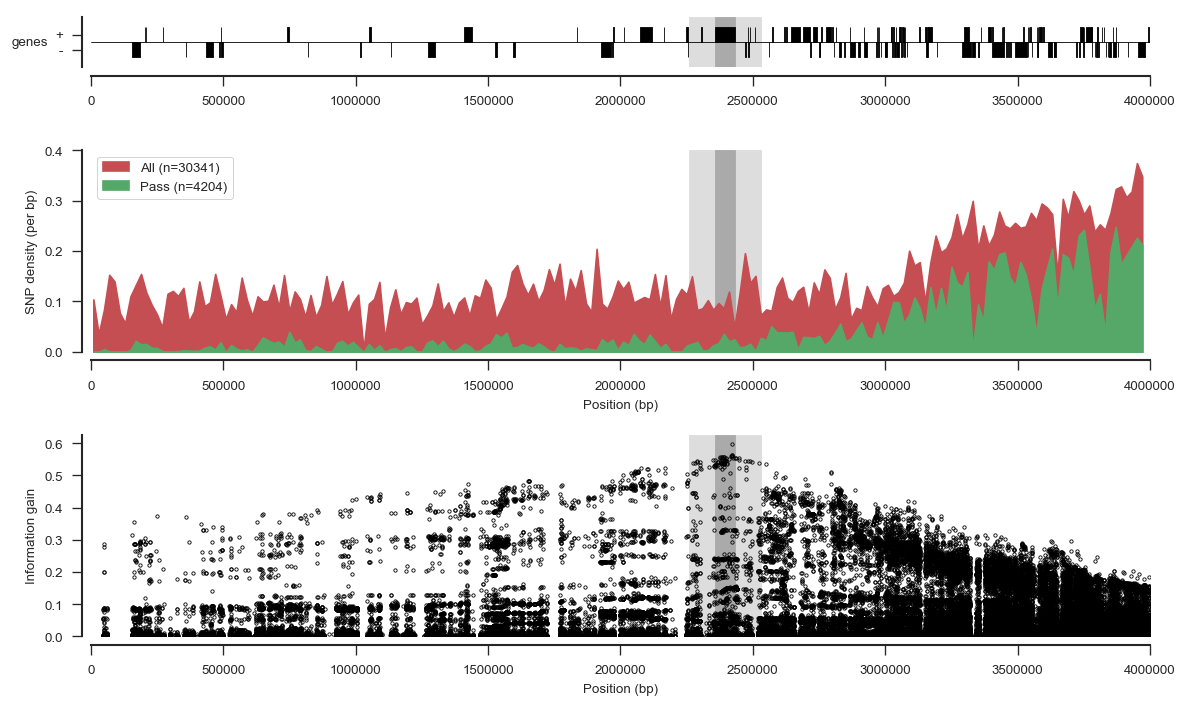

In [19]:
plot_diagnostics('2L', 1, 4e6, 2e4)

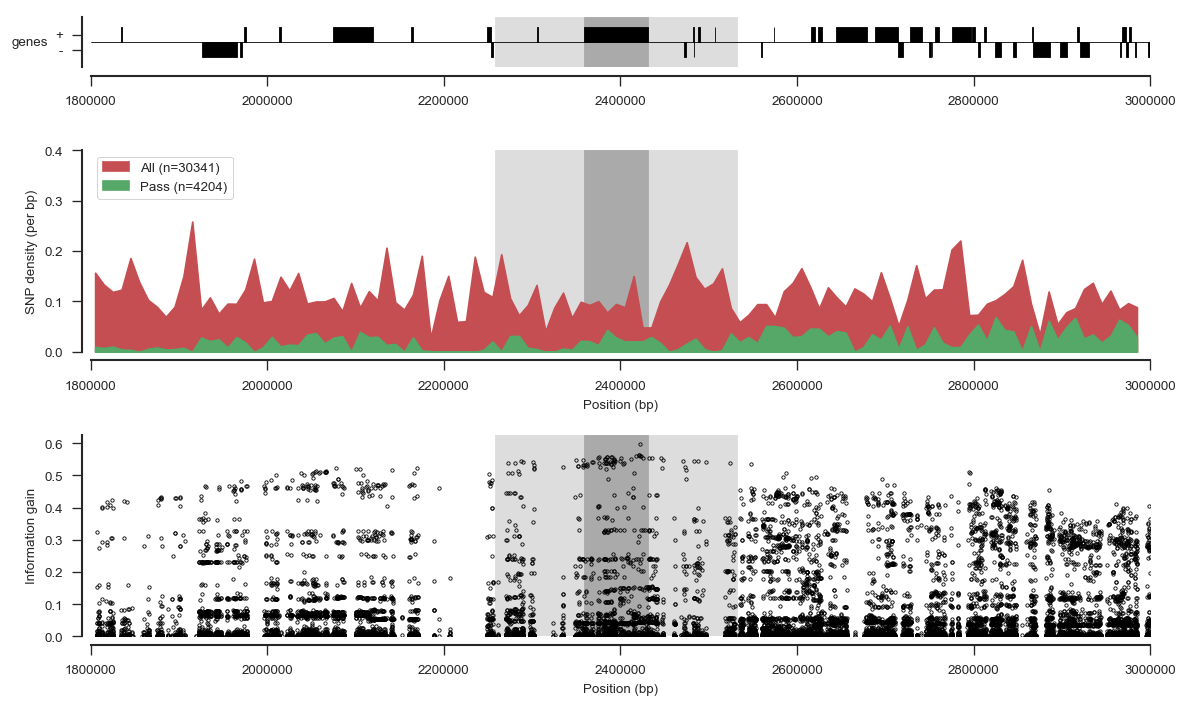

In [20]:
plot_diagnostics('2L', 1.8e6, 3e6, 1e4)